In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-deep')
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

<ipython-input-1-aa2dbc375f95>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv('/content/drive/MyDrive/AI/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


# Exploratory Data Analysis

In [5]:
df.groupby('category').describe()

text                                                            \
              count unique                                                top   
category                                                                        
business        510    503  economy  strong  in election year uk businesse...   
entertainment   386    369  ocean s twelve raids box office ocean s twelve...   
politics        417    403  super union  merger plan touted two of britain...   
sport           511    504  hantuchova in dubai last eight daniela hantuch...   
tech            401    347  california sets fines for spyware the makers o...   

                    
              freq  
category            
business         2  
entertainment    2  
politics         2  
sport            2  
tech             2

In [26]:
target_category = df['category'].unique()
print(target_category)

['tech' 'business' 'sport' 'entertainment' 'politics']


Let's make a new column to detect how long the text messages are

In [7]:
df['length'] = df['text'].apply(len)
df.head()

,category,text,length
0,tech,tv future in the hands of viewers with home th...,4333
1,business,worldcom boss left books alone former worldc...,1842
2,sport,tigers wary of farrell gamble leicester say ...,1342
3,sport,yeading face newcastle in fa cup premiership s...,2176
4,entertainment,ocean s twelve raids box office ocean s twelve...,1579


<Axes: ylabel='Frequency'>

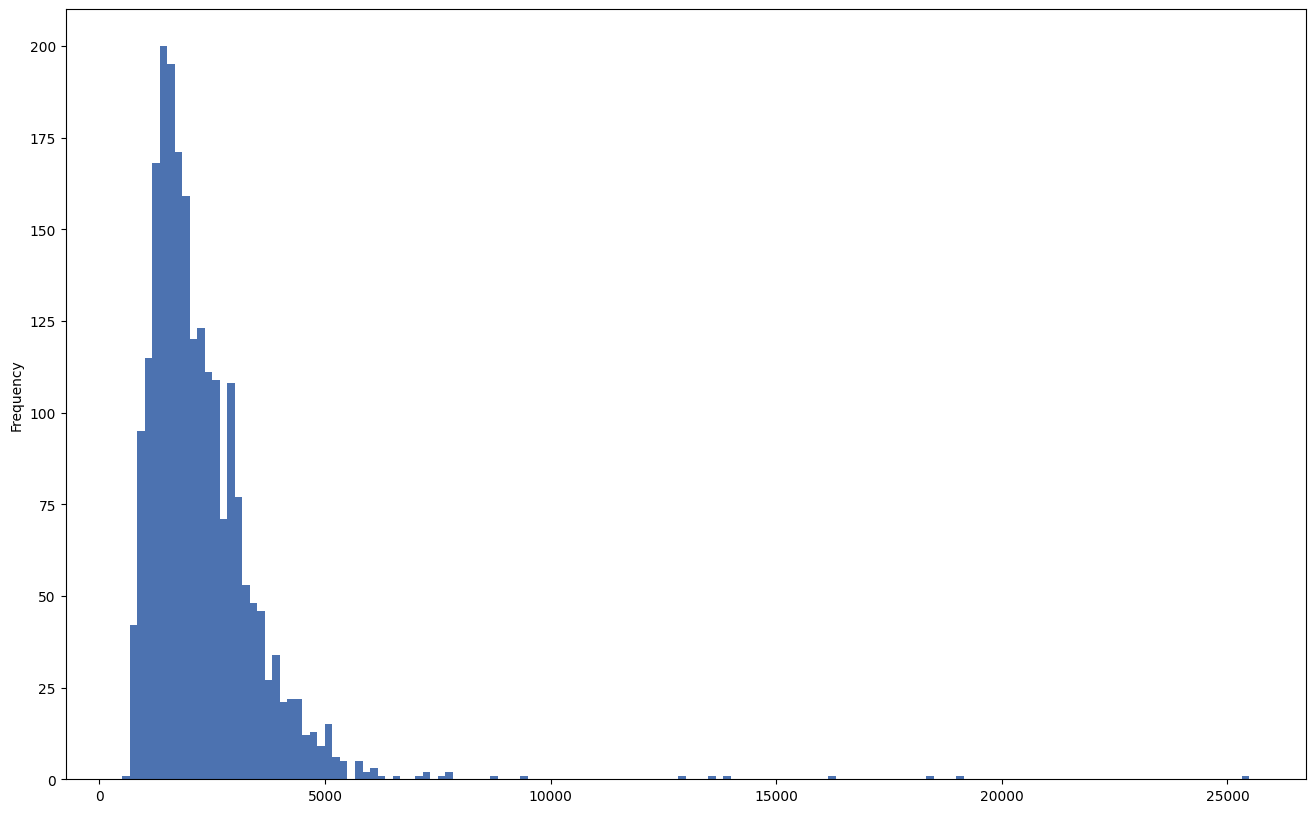

In [8]:
plt.figure(figsize = (16,10))
df['length'].plot.hist(bins = 150)

In [11]:
df['length'].describe()

count     2225.00000
mean      2262.93618
std       1364.10253
min        501.00000
25%       1446.00000
50%       1965.00000
75%       2802.00000
max      25483.00000
Name: length, dtype: float64

One of the text has 910 characters, let's use masking to find this message:

In [12]:
df[df['length'] == 501]

,category,text,length
323,politics,blunkett hints at election call ex-home secret...,501


# Text Cleaning

Let’s clean the text for the messages in our dataset with NLP.
Let's create the function to remove all punctuation, remove all stopwords and returns a list of the cleaned text

In [13]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Train Test Split

In [15]:
msg_train, msg_test, label_train, label_test = train_test_split(df['text'], df['category'], test_size=0.2,shuffle=True)

# SVC

In [16]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ SVM
])

In [18]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f5a588fbbe0>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [19]:
y_pred = pipeline.predict(msg_test)

In [24]:
train_accuracy = round(pipeline.score(msg_train, label_train)*100)
test_accuracy = round(pipeline.score(label_test, y_pred)*100)

print("SVC Train accuracy score : {}%.".format(train_accuracy))
print("SVC Test accuracy score : {}%.".format(test_accuracy))

SVC Train accuracy score : 100%.
SVC Test accuracy score : 82%.


In [27]:
print(classification_report(label_test, y_pred, target_names = target_category ))

               precision    recall  f1-score   support

         tech       0.97      0.94      0.96       107
     business       0.97      0.99      0.98        68
        sport       0.97      1.00      0.98        94
entertainment       0.98      0.99      0.99       102
     politics       0.97      0.95      0.96        74

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



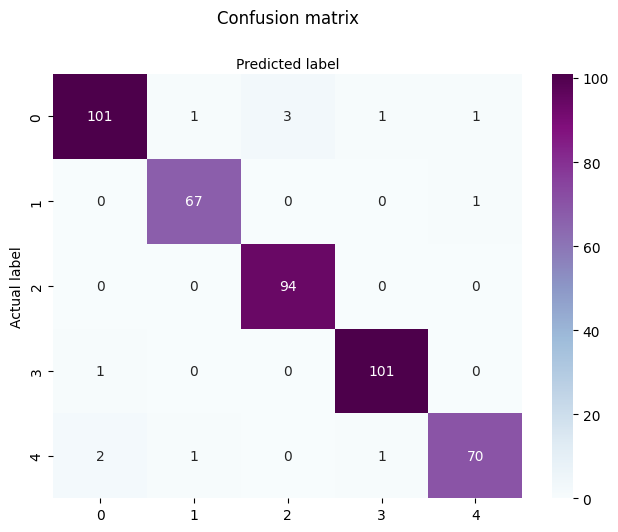

In [29]:
cm = confusion_matrix(label_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Naive Bayes

In [30]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('clf', MultinomialNB()),
])

In [31]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f5a588fbbe0>)),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [33]:
y_pred = pipeline.predict(msg_test)

In [34]:
train_accuracy = round(pipeline.score(msg_train, label_train)*100)
test_accuracy = round(pipeline.score(label_test, y_pred)*100)

print("Naive Baise Train accuracy: {}%".format(train_accuracy))
print("Naive Baise Test accuracy: {}%".format(test_accuracy))

Naive Baise Train accuracy: 99%
Naive Baise Test accuracy: 68%


In [37]:
print(classification_report(label_test, y_pred, target_names = target_category))

               precision    recall  f1-score   support

         tech       0.99      0.97      0.98       107
     business       1.00      0.96      0.98        68
        sport       0.96      1.00      0.98        94
entertainment       0.98      0.99      0.99       102
     politics       0.96      0.96      0.96        74

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



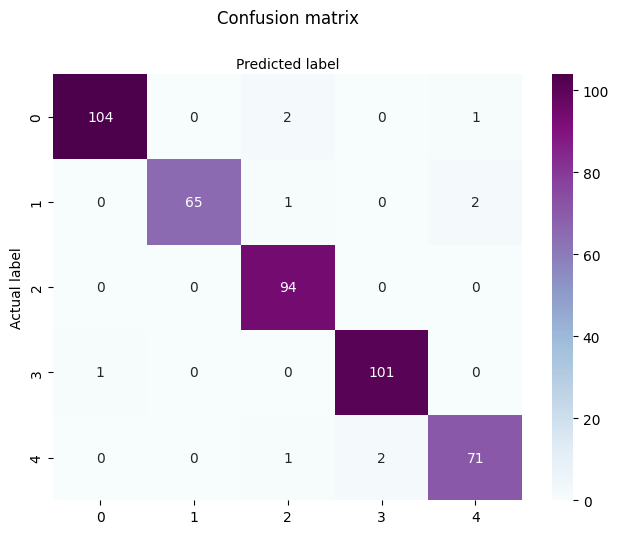

In [38]:
cm = confusion_matrix(label_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# KNN

In [40]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', KNeighborsClassifier(n_neighbors=7)),
])

In [41]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f5a588fbbe0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', KNeighborsClassifier(n_neighbors=7))])

In [42]:
y_pred = pipeline.predict(msg_test)

In [43]:
train_accuracy = round(pipeline.score(msg_train, label_train)*100)
test_accuracy = round(pipeline.score(label_test, y_pred)*100)

print(f"KNN Train accuracy: {train_accuracy}%")
print(f"KNN Test accuracy: {test_accuracy}%")

KNN Train accuracy: 96%
KNN Test accuracy: 81%


In [44]:
print(classification_report(label_test, y_pred, target_names = target_category))

               precision    recall  f1-score   support

         tech       0.97      0.88      0.92       107
     business       0.95      0.91      0.93        68
        sport       0.92      0.99      0.95        94
entertainment       0.95      0.99      0.97       102
     politics       0.93      0.96      0.95        74

     accuracy                           0.95       445
    macro avg       0.95      0.95      0.95       445
 weighted avg       0.95      0.95      0.95       445



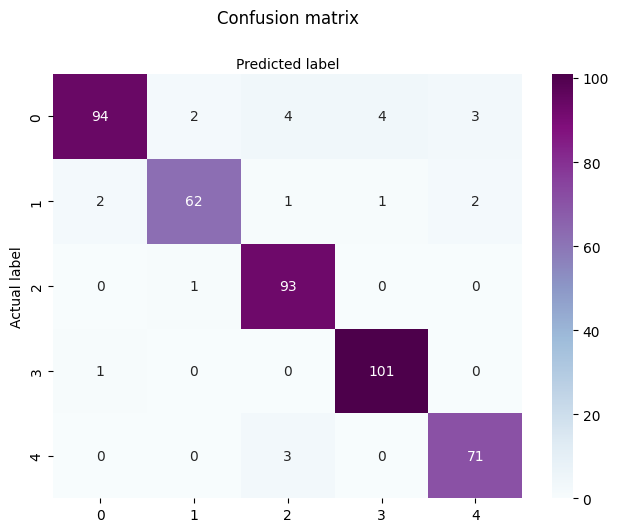

In [45]:
cm = confusion_matrix(label_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()